In [1]:
%pip install -U "datasets<3.0" "transformers>=4.45" peft accelerate evaluate \
    scikit-learn librosa soundfile matplotlib seaborn psutil pynvml

Note: you may need to restart the kernel to use updated packages.


In [2]:
# src/data_prep.py
import os, json, numpy as np, matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset, concatenate_datasets

SEED = 507
TARGET = ["yes","no","up","down","left","right","on","off","stop","go"]

def load_subset():
    ds = load_dataset("speech_commands", "v0.02", trust_remote_code=True)

    whole = concatenate_datasets([ds[s] for s in ["train","validation","test"]])

    label_names = ds["train"].features["label"].names          
    name2id = {name:i for i, name in enumerate(label_names)}
    target_ids = [name2id[n] for n in TARGET]

    sub = whole.filter(lambda ex: ex["label"] in target_ids)
    assert len(sub) > 0 

    return sub

def speaker_split(sub, save_path="splits/split_seed507.json"):

    labels   = np.array(sub["label"])
    speakers = np.array(sub["speaker_id"])

    from sklearn.model_selection import GroupShuffleSplit
    gss1 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    tv_idx, te_idx = next(gss1.split(labels, groups=speakers))

    gss2 = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED)
    tr_idx, va_idx = next(gss2.split(labels[tv_idx], groups=speakers[tv_idx]))

    train_idx = tv_idx[tr_idx].tolist()
    val_idx   = tv_idx[va_idx].tolist()
    test_idx  = te_idx.tolist()

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, "w") as f:
        json.dump({"train":train_idx,"val":val_idx,"test":test_idx}, f)
    return train_idx, val_idx, test_idx

def plot_class_dist(sub, save_path="figs/fig1_class_distribution.png"):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    cnt = Counter(sub["label"])
    label_names = sub.features["label"].names
    name2id = {name:i for i, name in enumerate(label_names)}
    xs = TARGET
    ys = [cnt.get(name2id[k], 0) for k in xs]
    plt.figure(figsize=(10,5))
    plt.bar(xs, ys)
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Count")
    plt.title("SpeechCommands v0.02 — 10-class distribution")
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

if __name__ == "__main__":
    sub = load_subset()
    print("Subset size:", len(sub))
    assert len(sub) > 0

    label_names = sub.features["label"].names
    name2id = {name: i for i, name in enumerate(label_names)}

    counts = {k: sub["label"].count(name2id[k]) for k in TARGET}
    print("Per-class counts:", counts)

    plot_class_dist(sub)

/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Subset size: 38546
Per-class counts: {'yes': 4044, 'no': 3941, 'up': 3723, 'down': 3917, 'left': 3801, 'right': 3778, 'on': 3845, 'off': 3745, 'stop': 3872, 'go': 3880}


In [3]:
import os, glob
print(os.getcwd())
print(os.path.exists("figs/fig1_class_distribution.png"))
print(glob.glob("figs/*.png"))


/Users/aaa
True
['figs/final_runtime_comparison.png', 'figs/fig4_confusion_matrix.png', 'figs/fig4_eval_acc.png', 'figs/fig4_loss_curve.png', 'figs/baseline_test_accuracy.png', 'figs/fig1b_per_split_counts.png', 'figs/baseline_test_macroF1.png', 'figs/fig6_eval_acc.png', 'figs/fig5_train_loss.png', 'figs/fig1c_no_wave_spec.png', 'figs/fig_data_efficiency.png', 'figs/fig1_class_distribution.png', 'figs/fig7_confusion_matrix.png', 'figs/fig1c_go_wave_spec.png', 'figs/final_speed_comparison.png', 'figs/final_perf_comparison.png']


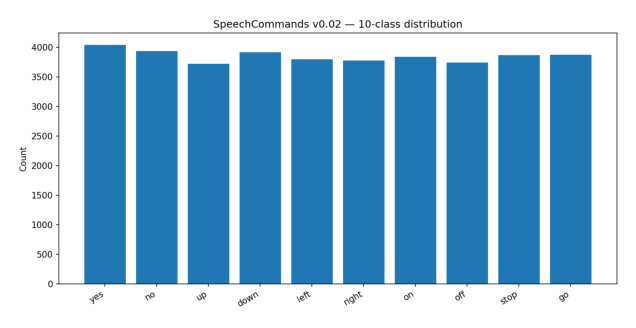

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("figs/fig1_class_distribution.png")
plt.figure(figsize=(8,4))
plt.imshow(img)
plt.axis("off")
plt.show()

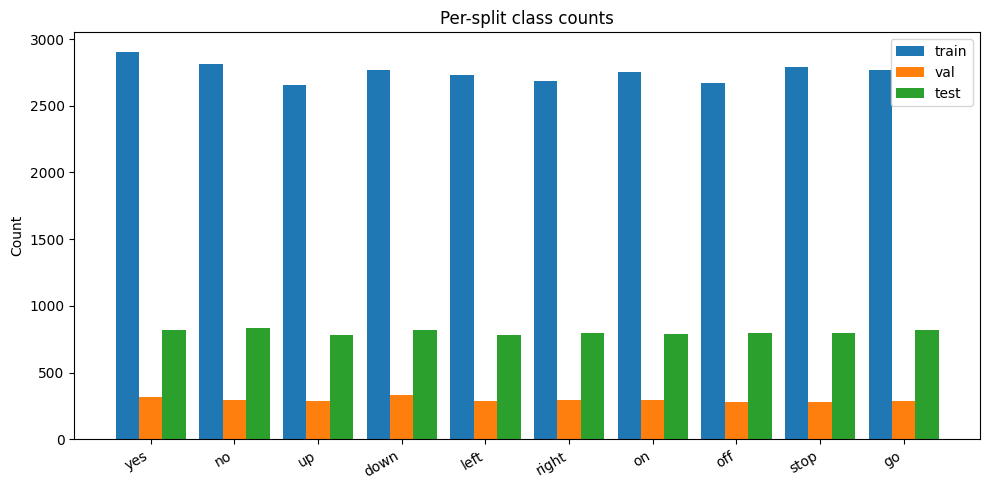

In [5]:
from collections import Counter
import numpy as np, matplotlib.pyplot as plt, json, os

train_idx, val_idx, test_idx = speaker_split(sub, "splits/split_seed507.json")

label_names = sub.features["label"].names
name2id = {n:i for i,n in enumerate(label_names)}

def count_on_index(idx):
    labs = [sub[i]["label"] for i in idx]
    c = Counter(labs)
    return [c.get(name2id[k], 0) for k in TARGET]

train_counts = count_on_index(train_idx)
val_counts   = count_on_index(val_idx)
test_counts  = count_on_index(test_idx)

x = np.arange(len(TARGET)); w = 0.28
plt.figure(figsize=(10,5))
plt.bar(x-w, train_counts, width=w, label="train")
plt.bar(x,   val_counts,   width=w, label="val")
plt.bar(x+w, test_counts,  width=w, label="test")
plt.xticks(x, TARGET, rotation=30, ha="right")
plt.ylabel("Count"); plt.title("Per-split class counts")
plt.legend(); plt.tight_layout()
os.makedirs("figs", exist_ok=True)
plt.savefig("figs/fig1b_per_split_counts.png", dpi=150); plt.show()

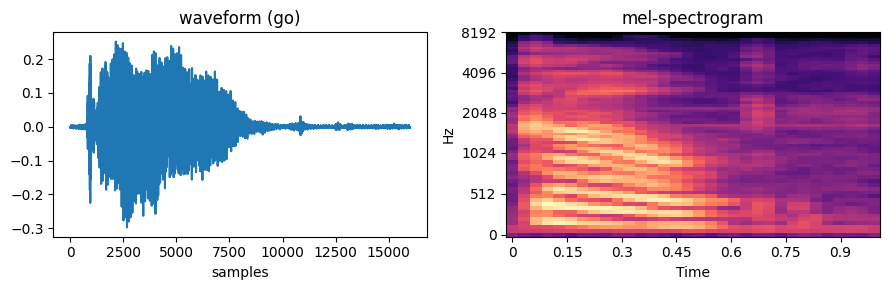

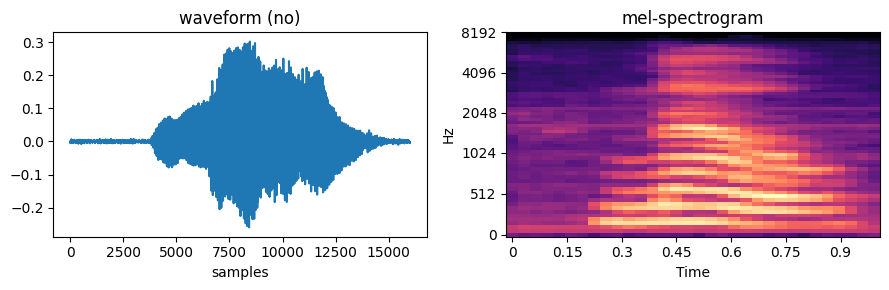

In [6]:
import numpy as np, matplotlib.pyplot as plt, librosa, librosa.display, os, random

def show_example(word="go"):
    lid = name2id[word]
    idx = next(i for i, lab in enumerate(sub["label"]) if lab == lid)
    y = np.array(sub[idx]["audio"]["array"])
    sr = sub[idx]["audio"]["sampling_rate"]

    plt.figure(figsize=(9,3))
    plt.subplot(1,2,1); plt.plot(y); plt.title(f"waveform ({word})"); plt.xlabel("samples")
    plt.subplot(1,2,2)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sr, x_axis="time", y_axis="mel")
    plt.title("mel-spectrogram"); plt.tight_layout()
    os.makedirs("figs", exist_ok=True)
    plt.savefig(f"figs/fig1c_{word}_wave_spec.png", dpi=150)
    plt.show()

show_example("go")
show_example("no")

In [7]:
try:
    import sklearn, seaborn as sns, librosa
    print("sklearn:", sklearn.__version__)
    print("librosa:", librosa.__version__)
    print("seaborn:", sns.__version__)
    print("All good")
except Exception as e:
    print("Missing library:", e)

sklearn: 1.7.2
librosa: 0.11.0
seaborn: 0.13.2
All good


In [8]:
import os, json, numpy as np
from datasets import load_dataset, concatenate_datasets
from sklearn.model_selection import GroupShuffleSplit

SEED   = 507
TARGET = ["yes","no","up","down","left","right","on","off","stop","go"]
SPLIT_JSON = "splits/split_seed507.json"

os.makedirs("splits", exist_ok=True)

In [9]:
def load_subset():
    ds = load_dataset("speech_commands", "v0.02", trust_remote_code=True)
    whole = concatenate_datasets([ds[s] for s in ["train","validation","test"]])

    label_names = ds["train"].features["label"].names
    name2id = {n:i for i,n in enumerate(label_names)}
    target_ids = [name2id[n] for n in TARGET]
    sub = whole.filter(lambda ex: ex["label"] in target_ids)
    return sub, label_names, name2id

sub, label_names, name2id = load_subset()
len(sub), label_names[:5]

(38546, ['yes', 'no', 'up', 'down', 'left'])

In [10]:
def ensure_split_json(sub, path=SPLIT_JSON, seed=SEED):
    if os.path.exists(path):
        with open(path) as f:
            j = json.load(f)
        return j["train"], j["val"], j["test"]

    labels   = np.array(sub["label"])
    speakers = np.array(sub["speaker_id"])
    gss1 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    tv_idx, te_idx = next(gss1.split(labels, groups=speakers))
    gss2 = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)
    tr_idx, va_idx = next(gss2.split(labels[tv_idx], groups=speakers[tv_idx]))
    train_idx = tv_idx[tr_idx].tolist()
    val_idx   = tv_idx[va_idx].tolist()
    test_idx  = te_idx.tolist()
    with open(path, "w") as f:
        json.dump({"train":train_idx, "val":val_idx, "test":test_idx}, f)
    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = ensure_split_json(sub)
len(train_idx), len(val_idx), len(test_idx)

(27547, 2969, 8030)

In [11]:
train_ds = sub.select(train_idx)
val_ds   = sub.select(val_idx)
test_ds  = sub.select(test_idx)

num_labels = len(TARGET)
id2label   = {i:n for i,n in enumerate(label_names)}
label2id   = {n:i for i,n in id2label.items() if n in TARGET} 
label2id = {k: name2id[k] for k in TARGET}  

len(train_ds), len(val_ds), len(test_ds), num_labels

(27547, 2969, 8030, 10)

In [12]:
#Wav2Vec2 pre-processor

In [13]:
import os
os.environ["DISABLE_TORCHVISION_IMPORT"] = "1"
os.environ["TRANSFORMERS_NO_TORCHVISION"] = "1" 

In [14]:
import sys, transformers, platform
print("Python exe:", sys.executable)
print("transformers file:", transformers.__file__)
print("transformers version:", transformers.__version__)
print("OS:", platform.platform())

/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Python exe: /opt/anaconda3/envs/pytorch310/bin/python
transformers file: /opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/__init__.py
transformers version: 4.57.3
OS: macOS-15.6.1-arm64-arm-64bit


In [15]:
from transformers import Wav2Vec2FeatureExtractor

MODEL_NAME = "facebook/wav2vec2-base"

try:
    fe = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_NAME, local_files_only=True)
except Exception:
    fe = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_NAME)

class SimpleProcessor:
    def __init__(self, fe): self.feature_extractor = fe
    def __call__(self, y, sampling_rate, return_tensors="pt", padding=False):
        return self.feature_extractor(
            y, sampling_rate=sampling_rate,
            return_tensors=return_tensors, padding=padding
        )

processor = SimpleProcessor(fe)
print("processor OK | sampling_rate =", processor.feature_extractor.sampling_rate)


processor OK | sampling_rate = 16000


In [16]:
example = train_ds[0] if 'train_ds' in globals() else sub[0]
y  = example["audio"]["array"]
sr = example["audio"]["sampling_rate"]

enc = processor([y], sampling_rate=sr, return_tensors="pt", padding=True)
print("raw len:", len(y), "| sr:", sr, "| input_values shape:", enc["input_values"].shape)

raw len: 16000 | sr: 16000 | input_values shape: torch.Size([1, 16000])


In [17]:
class SimpleProcessor:
    def __init__(self, fe):
        self.feature_extractor = fe

    def __call__(self, y, sampling_rate=None, return_tensors=None, **kwargs):
        return self.feature_extractor(
            y,
            sampling_rate=sampling_rate,
            return_tensors=return_tensors,
            **kwargs
        )

processor = SimpleProcessor(fe)
print("SimpleProcessor patched.")

SimpleProcessor patched.


In [18]:
import numpy as np

MAX_LEN = 16000
TARGET = ["yes","no","up","down","left","right","on","off","stop","go"]

id2label = {i: n for i, n in enumerate(TARGET)}
label2id = {n: i for i, n in enumerate(TARGET)}
num_labels = len(TARGET)

def preprocess_fn(batch):
    waves = [a["array"] for a in batch["audio"]]
    sr = batch["audio"][0]["sampling_rate"]

    out = processor(
        waves,
        sampling_rate=sr,
        return_tensors=None, 
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
    )
    out["labels"] = batch["label"]
    return out

cols_to_remove = [c for c in train_ds.column_names if c not in ["audio","label"]]

train_enc = train_ds.map(preprocess_fn, batched=True, remove_columns=cols_to_remove)
val_enc   = val_ds.map(preprocess_fn,   batched=True, remove_columns=cols_to_remove)
test_enc  = test_ds.map(preprocess_fn,  batched=True, remove_columns=cols_to_remove)

keep_cols = ["input_values","attention_mask","labels"]
train_enc = train_enc.remove_columns([c for c in train_enc.column_names if c not in keep_cols]).with_format("torch")
val_enc   = val_enc.remove_columns(  [c for c in val_enc.column_names   if c not in keep_cols]).with_format("torch")
test_enc  = test_enc.remove_columns( [c for c in test_enc.column_names  if c not in keep_cols]).with_format("torch")

print(train_enc[0].keys(), train_enc[0]["input_values"].shape, train_enc[0]["labels"])

dict_keys(['input_values', 'labels']) torch.Size([16000]) tensor(3)


In [19]:
import numpy as np

TARGET = ["yes","no","up","down","left","right","on","off","stop","go"]

label_names = train_ds.features["label"].names
name2global = {n:i for i,n in enumerate(label_names)}
global2local = {name2global[n]: i for i, n in enumerate(TARGET)}

def relabel_fn(batch):
    ids = batch["labels"]
    if hasattr(ids, "tolist"):          # torch.Tensor / np.ndarray
        ids = ids.tolist()
    if not isinstance(ids, (list, tuple)):
        ids = [ids]
    new_ids = [int(global2local[int(i)]) for i in ids]
    return {"labels": new_ids}

train_enc = train_enc.map(relabel_fn, batched=True)
val_enc   = val_enc.map(relabel_fn,   batched=True)
test_enc  = test_enc.map(relabel_fn,  batched=True)

id2label_local = {i:n for i, n in enumerate(TARGET)}
label2id_local = {n:i for i, n in id2label_local.items()}
print("relabel done.", id2label_local)

relabel done. {0: 'yes', 1: 'no', 2: 'up', 3: 'down', 4: 'left', 5: 'right', 6: 'on', 7: 'off', 8: 'stop', 9: 'go'}


In [20]:
print(train_enc[0]["labels"])
uniq = sorted(set(int(x) for x in train_enc["labels"]))
print("unique labels:", uniq)

tensor(3)
unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [21]:
import torch
from transformers import default_data_collator

device = (
    "cuda" if torch.cuda.is_available() else
    "mps"  if torch.backends.mps.is_available() else
    "cpu"
)
device

'mps'

In [22]:
import os
os.environ["DISABLE_TORCHVISION_IMPORT"] = "1"
os.environ["TRANSFORMERS_NO_TORCHVISION"] = "1"

In [23]:
import sys
print("torchvision in sys.modules? ", "torchvision" in sys.modules)
import transformers, importlib
print("transformers:", transformers.__version__)
mod = importlib.import_module("transformers.models.wav2vec2.modeling_wav2vec2")
print("has Wav2Vec2ForSequenceClassification:",
      hasattr(mod, "Wav2Vec2ForSequenceClassification"))

torchvision in sys.modules?  False
transformers: 4.57.3
has Wav2Vec2ForSequenceClassification: True


In [24]:
from transformers import AutoConfig, Wav2Vec2ForSequenceClassification
import torch

num_labels = len(TARGET)

config = AutoConfig.from_pretrained(
    MODEL_NAME,                      # "facebook/wav2vec2-base"
    num_labels=num_labels,
    id2label=id2label_local, 
    label2id=label2id_local, 
    problem_type="single_label_classification",
)

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config,
    ignore_mismatched_sizes=True,
)

if hasattr(model, "freeze_feature_encoder"):
    model.freeze_feature_encoder()

device = (
    "mps" if torch.backends.mps.is_available()
    else ("cuda" if torch.cuda.is_available() else "cpu")
)
model.to(device)
print("model device ->", device)

/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model device -> mps


In [25]:
import torch
from torch.utils.data import DataLoader

def collate_fn(batch):
    out = {
        "input_values": torch.stack([b["input_values"] for b in batch]),
        "labels": torch.tensor([int(b["labels"]) for b in batch]),
    }
    if "attention_mask" in batch[0]:
        out["attention_mask"] = torch.stack([b["attention_mask"] for b in batch])
    return out

loader = DataLoader(train_enc, batch_size=4, shuffle=False, collate_fn=collate_fn)
batch = next(iter(loader))
batch = {k: v.to(device) for k, v in batch.items()}

with torch.no_grad():
    out = model(**batch)

print("sanity loss:", float(out.loss), "| logits shape:", tuple(out.logits.shape))

sanity loss: 2.2449278831481934 | logits shape: (4, 10)


In [26]:
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=-1)
    labels = p.label_ids
    return {
        "acc": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }

args = TrainingArguments(
    output_dir="runs/w2v2_base_sc",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=1,
    learning_rate=5e-5,
    warmup_ratio=0.1,
    num_train_epochs=1, 
    logging_steps=50,
    report_to="none",
    fp16=False, bf16=False, 
)

In [27]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_enc,
    eval_dataset=val_enc,
    data_collator=collate_fn,
    tokenizer=None,
    compute_metrics=compute_metrics,
)

train_result = trainer.train()
print(train_result)

/var/folders/kn/_mdpl6lj133bj76v5x383z1w0000gn/T/ipykernel_35485/894475193.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
50,2.296900
100,2.285700
150,2.241000
200,2.040600
250,1.643700
300,1.477000
350,1.213200
400,1.138200
450,1.028700
500,0.889100


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch

TrainOutput(global_step=3444, training_loss=0.6358203863017651, metrics={'train_runtime': 999.9778, 'train_samples_per_second': 27.548, 'train_steps_per_second': 3.444, 'total_flos': 2.50094530450752e+17, 'train_loss': 0.6358203863017651, 'epoch': 1.0})


In [28]:
val_metrics  = trainer.evaluate(val_enc)
test_metrics = trainer.evaluate(test_enc)
print("VAL:",  val_metrics)
print("TEST:", test_metrics)

/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


VAL: {'eval_loss': 0.15901197493076324, 'eval_acc': 0.96497137083193, 'eval_f1_macro': 0.9646940448603927, 'eval_runtime': 32.8662, 'eval_samples_per_second': 90.336, 'eval_steps_per_second': 11.319, 'epoch': 1.0}
TEST: {'eval_loss': 0.12111785262823105, 'eval_acc': 0.9718555417185554, 'eval_f1_macro': 0.9717937108878942, 'eval_runtime': 92.3755, 'eval_samples_per_second': 86.928, 'eval_steps_per_second': 10.869, 'epoch': 1.0}


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

         yes     0.9866    0.9902    0.9884       820
          no     0.9749    0.9796    0.9772       832
          up     0.9334    0.9526    0.9429       780
        down     0.9559    0.9804    0.9680       818
        left     0.9333    0.9872    0.9595       779
       right     0.9987    0.9849    0.9918       794
          on     0.9846    0.9697    0.9771       791
         off     0.9728    0.9447    0.9586       796
        stop     0.9962    0.9737    0.9848       798
          go     0.9849    0.9550    0.9697       822

    accuracy                         0.9719      8030
   macro avg     0.9721    0.9718    0.9718      8030
weighted avg     0.9723    0.9719    0.9719      8030



<Figure size 800x600 with 0 Axes>

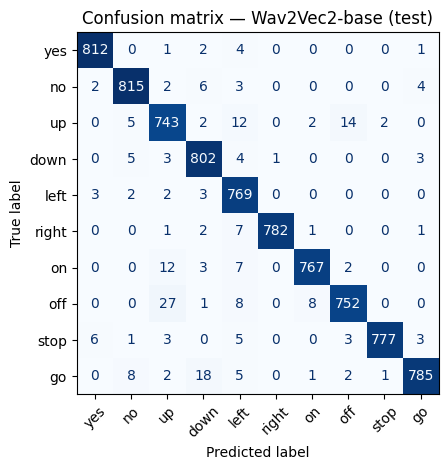

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.special import softmax

pred = trainer.predict(test_enc)

y_true = pred.label_ids
y_prob = softmax(pred.predictions, axis=1)
y_pred = y_prob.argmax(axis=1)

labels = [id2label_local[i] for i in range(len(id2label_local))]

print(classification_report(y_true, y_pred, target_names=labels, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', xticks_rotation=45, colorbar=False, values_format='d')
plt.title("Confusion matrix — Wav2Vec2-base (test)")
plt.tight_layout()
import os; os.makedirs("figs", exist_ok=True)
plt.savefig("figs/fig4_confusion_matrix.png", dpi=160)
plt.show()

In [30]:
wrong_idx = np.where(y_pred != y_true)[0]
for i in wrong_idx:
    print(f"[{i:5d}] true={id2label_local[int(y_true[i])]:>5s}  pred={id2label_local[int(y_pred[i])]:>5s}")

[   78] true= down  pred= left
[  124] true= down  pred=   up
[  172] true= down  pred= left
[  309] true= down  pred=right
[  330] true= down  pred= left
[  378] true= down  pred=   go
[  382] true= down  pred=   up
[  433] true= down  pred=   no
[  507] true= down  pred= left
[  519] true= down  pred=   no
[  522] true= down  pred=   go
[  594] true= down  pred=   no
[  625] true= down  pred=   no
[  637] true= down  pred=   up
[  728] true=   go  pred= down
[  737] true=   go  pred= down
[  748] true=   go  pred= left
[  756] true=   go  pred=   no
[  760] true=   go  pred=   on
[  792] true=   go  pred= down
[  857] true=   go  pred=   no
[  870] true=   go  pred= down
[  925] true=   go  pred=   no
[  937] true=   go  pred= down
[  950] true=   go  pred= down
[  963] true=   go  pred= down
[ 1004] true=   go  pred=   no
[ 1005] true=   go  pred=   no
[ 1009] true=   go  pred= stop
[ 1024] true=   go  pred= left
[ 1038] true=   go  pred= down
[ 1075] true=   go  pred=  off
[ 1081] 

<Figure size 700x400 with 0 Axes>

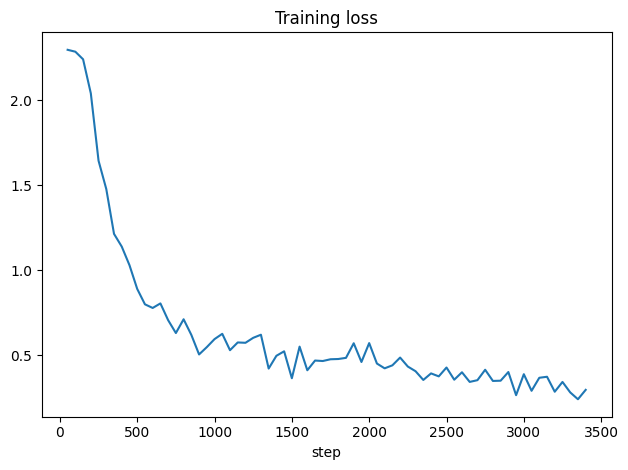

<Figure size 700x400 with 0 Axes>

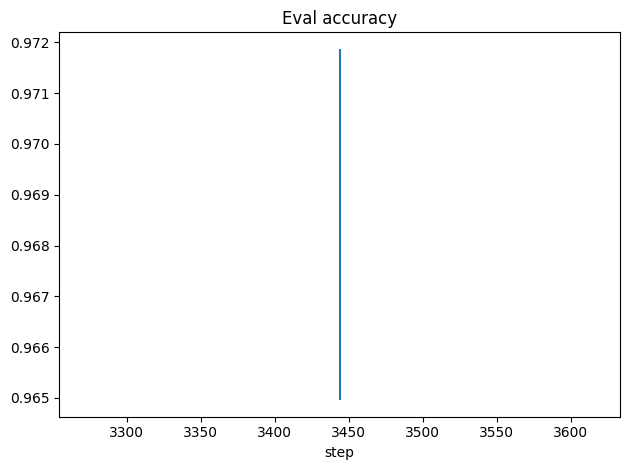

In [31]:
import pandas as pd
hist = pd.DataFrame(trainer.state.log_history)

plt.figure(figsize=(7,4))
hist.loc[hist["loss"].notna(), :].plot(x="step", y="loss", legend=False)
plt.title("Training loss")
plt.tight_layout()
plt.savefig("figs/fig4_loss_curve.png", dpi=160)
plt.show()

if "eval_acc" in hist:
    plt.figure(figsize=(7,4))
    hist.loc[hist["eval_acc"].notna(), :].plot(x="step", y="eval_acc", legend=False)
    plt.title("Eval accuracy")
    plt.tight_layout()
    plt.savefig("figs/fig4_eval_acc.png", dpi=160)
    plt.show()

In [32]:
save_dir = "runs/w2v2_base_sc_best"
trainer.save_model(save_dir)
model.config.id2label = id2label_local
model.config.label2id = label2id_local
model.config.save_pretrained(save_dir)

processor.feature_extractor.save_pretrained(save_dir)
print("saved to:", save_dir)

saved to: runs/w2v2_base_sc_best


In [33]:
import librosa
import torch

TARGET_SR = 16000
device = next(model.parameters()).device

@torch.no_grad()
def predict_file(path):
    y, sr = librosa.load(path, sr=TARGET_SR)
    inputs = processor([y], sampling_rate=TARGET_SR, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    logits = model(**inputs).logits
    pred_id = int(logits.argmax(dim=-1).item())
    return id2label_local[pred_id]

In [34]:
import json
metrics = {
    "val":  val_metrics,
    "test": test_metrics
}
os.makedirs("runs", exist_ok=True)
with open("runs/metrics_w2v2_base.json", "w") as f:
    json.dump(metrics, f, indent=2)
print("metrics saved to runs/metrics_w2v2_base.json")

metrics saved to runs/metrics_w2v2_base.json


In [35]:
import os, json, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

os.makedirs("figs", exist_ok=True)
os.makedirs("runs", exist_ok=True)

pred = trainer.predict(test_enc)
y_true = pred.label_ids
y_pred = pred.predictions.argmax(axis=1)

acc  = accuracy_score(y_true, y_pred)
f1m  = f1_score(y_true, y_pred, average="macro")
report = classification_report(y_true, y_pred, target_names=TARGET, digits=4)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=TARGET)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
plt.title("Confusion matrix (test)")
plt.tight_layout()
plt.savefig("figs/fig4_confusion_matrix.png", dpi=150)
plt.close()

# per-class acc
per_class_acc = (cm.diagonal() / cm.sum(axis=1)).tolist()

metrics = {
    "val": val_metrics,
    "test": {
        "acc": acc, "f1_macro": f1m,
        "per_class_acc": dict(zip(TARGET, per_class_acc)),
        "report": report
    }
}
with open("runs/metrics_w2v2_base.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("saved: runs/metrics_w2v2_base.json, figs/fig4_confusion_matrix.png")
print(report)

/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


saved: runs/metrics_w2v2_base.json, figs/fig4_confusion_matrix.png
              precision    recall  f1-score   support

         yes     0.9866    0.9902    0.9884       820
          no     0.9749    0.9796    0.9772       832
          up     0.9334    0.9526    0.9429       780
        down     0.9559    0.9804    0.9680       818
        left     0.9333    0.9872    0.9595       779
       right     0.9987    0.9849    0.9918       794
          on     0.9846    0.9697    0.9771       791
         off     0.9728    0.9447    0.9586       796
        stop     0.9962    0.9737    0.9848       798
          go     0.9849    0.9550    0.9697       822

    accuracy                         0.9719      8030
   macro avg     0.9721    0.9718    0.9718      8030
weighted avg     0.9723    0.9719    0.9719      8030



In [36]:
save_dir = "runs/w2v2_base_sc_best"
os.makedirs(save_dir, exist_ok=True)

model.save_pretrained(save_dir)
processor.feature_extractor.save_pretrained(save_dir)
print("model saved to", save_dir)

model saved to runs/w2v2_base_sc_best


In [37]:
from collections import Counter
pairs = Counter(
    (id2label_local[t], id2label_local[p])
    for t, p in zip(y_true, y_pred) if t != p
).most_common(5)
print("Top confusions:", pairs)

mis_idx = np.where(y_true != y_pred)[0][:10]
print("Examples misclassified idx -> (true, pred):")
for i in mis_idx:
    print(i, id2label_local[y_true[i]], "->", id2label_local[y_pred[i]])

Top confusions: [(('off', 'up'), 27), (('go', 'down'), 18), (('up', 'off'), 14), (('on', 'up'), 12), (('up', 'left'), 12)]
Examples misclassified idx -> (true, pred):
78 down -> left
124 down -> up
172 down -> left
309 down -> right
330 down -> left
378 down -> go
382 down -> up
433 down -> no
507 down -> left
519 down -> no


In [38]:
import torch, librosa, numpy as np

def predict_file(path, max_len=MAX_LEN, sr=TARGET_SR):
    y, s = librosa.load(path, sr=sr)
    enc = processor([y], sampling_rate=sr, return_tensors="pt", padding="max_length", truncation=True, max_length=max_len)
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        logits = model(**enc).logits
    pred_id = int(logits.argmax(-1).item())
    return id2label_local[pred_id]

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(trainer.state.log_history)
train_log = df[df["loss"].notna()][["step","loss"]]
plt.figure(figsize=(6,4))
plt.plot(train_log["step"], train_log["loss"])
plt.xlabel("step"); plt.ylabel("train loss"); plt.title("Training loss")
plt.tight_layout(); plt.savefig("figs/fig5_train_loss.png", dpi=150); plt.close()

if "eval_acc" in df.columns:
    eval_log = df[df["eval_acc"].notna()][["step","eval_acc"]]
    plt.figure(figsize=(6,4))
    plt.plot(eval_log["step"], eval_log["eval_acc"])
    plt.xlabel("step"); plt.ylabel("eval acc"); plt.title("Eval acc")
    plt.tight_layout(); plt.savefig("figs/fig6_eval_acc.png", dpi=150); plt.close()

print("curves saved to figs/")

curves saved to figs/


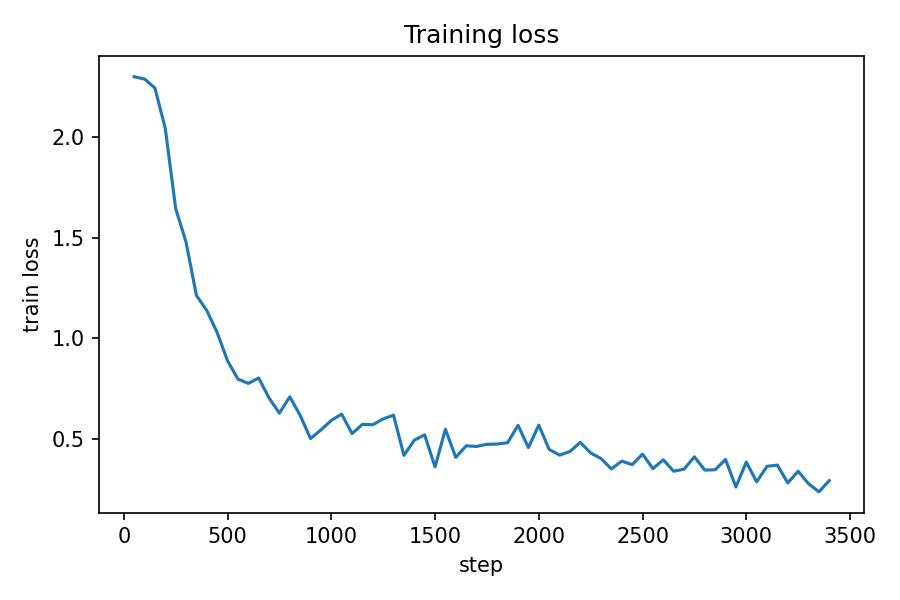

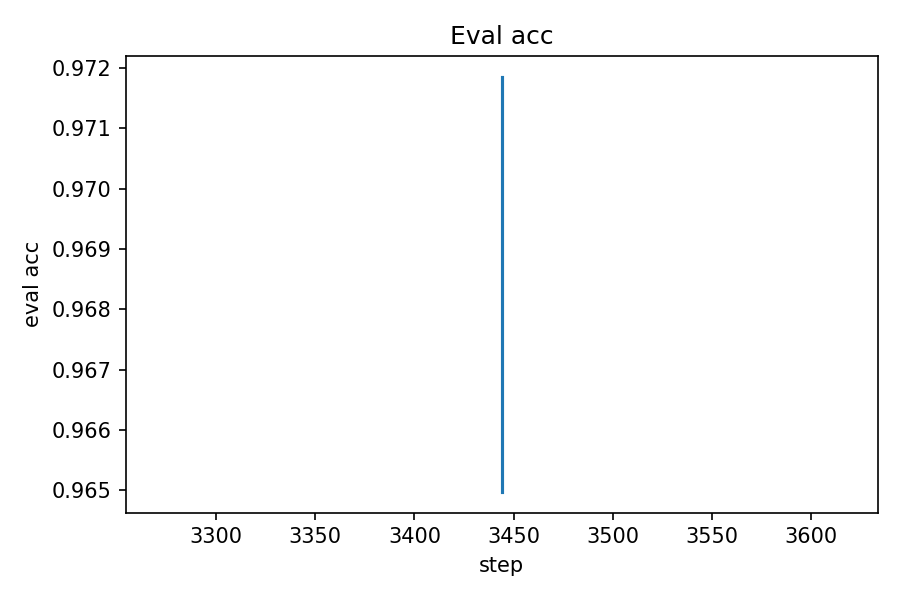

In [40]:
from IPython.display import Image, display

display(Image(filename="figs/fig5_train_loss.png"))
display(Image(filename="figs/fig6_eval_acc.png"))

In [41]:
def freeze_feature_encoder(model):
    model.freeze_feature_encoder()
def unfreeze_all(model):
    for p in model.parameters():
        p.requires_grad = True

def partial_unfreeze_last2(model):
    for n, p in model.named_parameters():
        p.requires_grad = False
        if "classifier" in n or "projector" in n:
            p.requires_grad = True
        if "wav2vec2.encoder.layers." in n:
            try:
                idx = int(n.split("encoder.layers.")[1].split(".")[0])
                if idx >= 10: 
                    p.requires_grad = True
            except:
                pass

/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


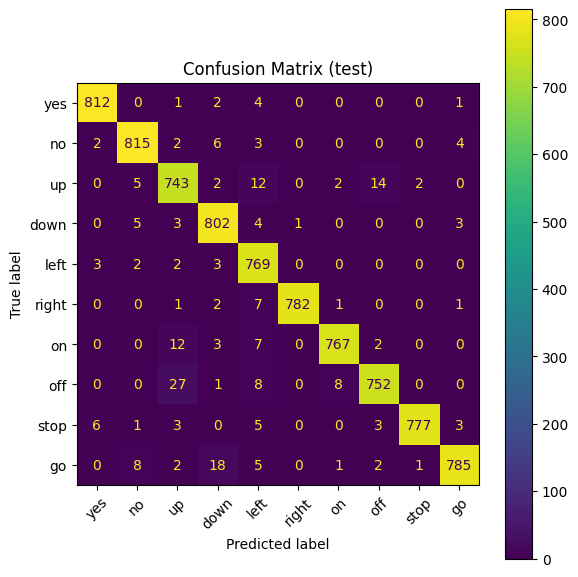

              precision    recall  f1-score   support

         yes     0.9866    0.9902    0.9884       820
          no     0.9749    0.9796    0.9772       832
          up     0.9334    0.9526    0.9429       780
        down     0.9559    0.9804    0.9680       818
        left     0.9333    0.9872    0.9595       779
       right     0.9987    0.9849    0.9918       794
          on     0.9846    0.9697    0.9771       791
         off     0.9728    0.9447    0.9586       796
        stop     0.9962    0.9737    0.9848       798
          go     0.9849    0.9550    0.9697       822

    accuracy                         0.9719      8030
   macro avg     0.9721    0.9718    0.9718      8030
weighted avg     0.9723    0.9719    0.9719      8030

Saved: figs/fig7_confusion_matrix.png, ckpt/wav2vec2_base_sc/, predictions_test.csv


In [42]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

os.makedirs("figs", exist_ok=True)
os.makedirs("ckpt", exist_ok=True)

pred = trainer.predict(test_enc)
y_true = np.asarray(test_enc["labels"])
y_pred = pred.predictions.argmax(-1)

labels = list(range(len(TARGET)))
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=TARGET)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, xticks_rotation=45, colorbar=True)
plt.title("Confusion Matrix (test)")
plt.tight_layout()
plt.savefig("figs/fig7_confusion_matrix.png", dpi=150)
plt.show()

print(classification_report(y_true, y_pred, target_names=TARGET, digits=4))

model.save_pretrained("ckpt/wav2vec2_base_sc")
processor.feature_extractor.save_pretrained("ckpt/wav2vec2_base_sc")

pd.DataFrame({"y_true": y_true, "y_pred": y_pred}).to_csv("predictions_test.csv", index=False)

print("Saved: figs/fig7_confusion_matrix.png, ckpt/wav2vec2_base_sc/, predictions_test.csv")

In [43]:
from transformers import AutoConfig, Wav2Vec2ForSequenceClassification, TrainingArguments, Trainer
import numpy as np

def build_model():
    cfg = AutoConfig.from_pretrained(
        MODEL_NAME,
        num_labels=len(TARGET),
        id2label=id2label_local,
        label2id=label2id_local,
        problem_type="single_label_classification",
    )
    return Wav2Vec2ForSequenceClassification.from_pretrained(
        MODEL_NAME, config=cfg, ignore_mismatched_sizes=True
    ).to(device)

common_args = dict(
    per_device_train_batch_size=8, per_device_eval_batch_size=8,
    gradient_accumulation_steps=1, learning_rate=5e-5, warmup_ratio=0.1,
    num_train_epochs=1, logging_steps=50, report_to="none",
    fp16=False, bf16=False,
)

In [44]:
# ----- B -----
model_B = build_model()
unfreeze_all(model_B)
args_B = TrainingArguments(output_dir="runs/w2v2_base_sc_B", **common_args)
trainer_B = Trainer(model=model_B, args=args_B,
                    train_dataset=train_enc, eval_dataset=val_enc,
                    data_collator=collate_fn, compute_metrics=compute_metrics)
trainer_B.train()
val_B  = trainer_B.evaluate(val_enc)
test_B = trainer_B.evaluate(test_enc)
print("B VAL:", val_B); print("B TEST:", test_B)
model_B.save_pretrained("ckpt/wav2vec2_base_sc_B")

/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,2.302700
100,2.285300
150,2.183900
200,1.872300
250,1.548700
300,1.283300
350,1.086200
400,1.070600
450,0.916500
500,0.863000


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


B VAL: {'eval_loss': 0.1495852917432785, 'eval_acc': 0.9693499494779387, 'eval_f1_macro': 0.969142853602699, 'eval_runtime': 33.0694, 'eval_samples_per_second': 89.781, 'eval_steps_per_second': 11.249, 'epoch': 1.0}
B TEST: {'eval_loss': 0.1375904083251953, 'eval_acc': 0.9691158156911581, 'eval_f1_macro': 0.9691096150746539, 'eval_runtime': 93.5922, 'eval_samples_per_second': 85.798, 'eval_steps_per_second': 10.727, 'epoch': 1.0}


In [45]:
# ----- C -----
model_C = build_model()
partial_unfreeze_last2(model_C)
args_C = TrainingArguments(output_dir="runs/w2v2_base_sc_C", **common_args)
trainer_C = Trainer(model=model_C, args=args_C,
                    train_dataset=train_enc, eval_dataset=val_enc,
                    data_collator=collate_fn, compute_metrics=compute_metrics)
trainer_C.train()
val_C  = trainer_C.evaluate(val_enc)
test_C = trainer_C.evaluate(test_enc)
print("C VAL:", val_C); print("C TEST:", test_C)
model_C.save_pretrained("ckpt/wav2vec2_base_sc_C")

/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,2.300600
100,2.284500
150,2.256500
200,2.189100
250,2.043600
300,1.838100
350,1.566600
400,1.392100
450,1.104100
500,0.924600


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


C VAL: {'eval_loss': 0.15513494610786438, 'eval_acc': 0.9501515661839003, 'eval_f1_macro': 0.9497572002824235, 'eval_runtime': 32.7767, 'eval_samples_per_second': 90.583, 'eval_steps_per_second': 11.35, 'epoch': 1.0}
C TEST: {'eval_loss': 0.13029149174690247, 'eval_acc': 0.9584059775840598, 'eval_f1_macro': 0.958320970576105, 'eval_runtime': 90.3093, 'eval_samples_per_second': 88.917, 'eval_steps_per_second': 11.117, 'epoch': 1.0}


In [46]:
summary = {
    "A(freeze)": {"val": val_metrics, "test": test_metrics},
    "B(full-ft)": {"val": val_B, "test": test_B},
    "C(last2-ft)": {"val": val_C, "test": test_C},
}
for k, v in summary.items():
    print(k, "→",
          "val_acc:",  round(v["val"]["eval_acc"], 4),
          "test_acc:", round(v["test"]["eval_acc"], 4),
          "test_f1:",  round(v["test"]["eval_f1_macro"], 4))

A(freeze) → val_acc: 0.965 test_acc: 0.9719 test_f1: 0.9718
B(full-ft) → val_acc: 0.9693 test_acc: 0.9691 test_f1: 0.9691
C(last2-ft) → val_acc: 0.9502 test_acc: 0.9584 test_f1: 0.9583


In [47]:
!pip install -U peft

In [48]:
from transformers import AutoConfig, Wav2Vec2ForSequenceClassification
from peft import LoraConfig, get_peft_model
from types import MethodType

num_labels = len(TARGET)

cfg = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label_local,
    label2id=label2id_local,
    problem_type="single_label_classification",
)

base_model = Wav2Vec2ForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=cfg,
    ignore_mismatched_sizes=True,
)


def dummy_enable_input_require_grads(self, *args, **kwargs):
    return

base_model.enable_input_require_grads = MethodType(
    dummy_enable_input_require_grads, base_model
)

def dummy_get_input_embeddings(self):
    return None
base_model.get_input_embeddings = MethodType(dummy_get_input_embeddings, base_model)

lora_cfg = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none", 
    target_modules=["q_proj", "k_proj", "v_proj", "out_proj"],
)


model_L = get_peft_model(base_model, lora_cfg)

model_L.print_trainable_parameters()

model_L.to(device)

print("LoRA model ready on", device)

/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,179,648 || all params: 95,750,794 || trainable%: 1.2320
LoRA model ready on mps:0


In [49]:
from transformers import TrainingArguments, Trainer

args_L = TrainingArguments(
    output_dir="runs/w2v2_base_sc_LoRA",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=1,
    learning_rate=5e-4,
    warmup_ratio=0.1,
    num_train_epochs=1,
    logging_steps=50,
    report_to="none",
    fp16=False,
    bf16=False,
)

In [50]:
trainer_L = Trainer(
    model=model_L,
    args=args_L,
    train_dataset=train_enc,
    eval_dataset=val_enc,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)
train_result_L = trainer_L.train()
val_metrics_L  = trainer_L.evaluate(val_enc)
test_metrics_L = trainer_L.evaluate(test_enc)
print("LoRA VAL:", val_metrics_L)
print("LoRA TEST:", test_metrics_L)

/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,2.301800
100,2.294100
150,2.204400
200,2.029600
250,1.920600
300,1.690700
350,1.505100
400,1.447900
450,1.369800
500,1.328600


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and wi

/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


LoRA VAL: {'eval_loss': 0.9997096657752991, 'eval_acc': 0.9703603907039408, 'eval_f1_macro': 0.9701285093063298, 'eval_runtime': 39.6264, 'eval_samples_per_second': 74.925, 'eval_steps_per_second': 9.388, 'epoch': 1.0}
LoRA TEST: {'eval_loss': 1.0023090839385986, 'eval_acc': 0.9712328767123287, 'eval_f1_macro': 0.9713171547888763, 'eval_runtime': 112.8132, 'eval_samples_per_second': 71.18, 'eval_steps_per_second': 8.9, 'epoch': 1.0}


In [51]:
import os, json

save_dir_L = "ckpt/wav2vec2_base_sc_LoRA"
os.makedirs(save_dir_L, exist_ok=True)

model_L.save_pretrained(save_dir_L)

processor.feature_extractor.save_pretrained(save_dir_L)
metrics_L = {
    "val":  val_metrics_L,
    "test": test_metrics_L,
}
os.makedirs("runs", exist_ok=True)
with open("runs/metrics_w2v2_LoRA.json", "w") as f:
    json.dump(metrics_L, f, indent=2)

print(" LoRA saved to", save_dir_L, "and runs/metrics_w2v2_LoRA.json")

 LoRA saved to ckpt/wav2vec2_base_sc_LoRA and runs/metrics_w2v2_LoRA.json


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [52]:
summary = {
    "A(freeze)": {"val": val_metrics,     "test": test_metrics},
    "B(full-ft)": {"val": val_B,          "test": test_B},
    "C(last2-ft)": {"val": val_C,         "test": test_C},
    "L(LoRA)": {"val": val_metrics_L,     "test": test_metrics_L},
}

for k, v in summary.items():
    print(k, "→",
          "val_acc:",  round(v["val"]["eval_acc"], 4),
          "test_acc:", round(v["test"]["eval_acc"], 4),
          "val_f1:",   round(v["val"]["eval_f1_macro"], 4),
          "test_f1:",  round(v["test"]["eval_f1_macro"], 4),
    )

A(freeze) → val_acc: 0.965 test_acc: 0.9719 val_f1: 0.9647 test_f1: 0.9718
B(full-ft) → val_acc: 0.9693 test_acc: 0.9691 val_f1: 0.9691 test_f1: 0.9691
C(last2-ft) → val_acc: 0.9502 test_acc: 0.9584 val_f1: 0.9498 test_f1: 0.9583
L(LoRA) → val_acc: 0.9704 test_acc: 0.9712 val_f1: 0.9701 test_f1: 0.9713


In [53]:
import torch

print(torch.mps.current_allocated_memory() / 1024**2)
print(torch.mps.driver_allocated_memory() / 1024**2)

3748.77587890625
5363.4375


In [54]:
import pandas as pd

def get_train_speed_from_trainer(trainer):
    record = None
    for r in reversed(trainer.state.log_history):
        if "train_runtime" in r:
            record = r
            break

    if record is None:
        raise ValueError("ERROR")

    runtime = float(record["train_runtime"])
    samples_per_sec = record.get("train_samples_per_second")
    steps_per_sec = record.get("train_steps_per_second")
    epoch = float(record.get("epoch", 1.0))

    return {
        "train_runtime_s": round(runtime, 2),
        "epoch_time_s":    round(runtime / epoch, 2),
        "train_samples_per_second": (
            round(samples_per_sec, 2) if samples_per_sec is not None else None
        ),
        "train_steps_per_second": (
            round(steps_per_sec, 3) if steps_per_sec is not None else None
        ),
    }

cost_perf = {
    "A(freeze)":  get_train_speed_from_trainer(trainer),
    "B(full-ft)": get_train_speed_from_trainer(trainer_B),
    "C(last2-ft)": get_train_speed_from_trainer(trainer_C),
    "L(LoRA)":    get_train_speed_from_trainer(trainer_L),
}

df_cost = pd.DataFrame(cost_perf).T
display(df_cost)
print(df_cost)

,train_runtime_s,epoch_time_s,train_samples_per_second,train_steps_per_second
A(freeze),999.98,999.98,27.55,3.444
B(full-ft),1475.58,1475.58,18.67,2.334
C(last2-ft),1105.31,1105.31,24.92,3.116
L(LoRA),1140.96,1140.96,24.14,3.019


             train_runtime_s  epoch_time_s  train_samples_per_second  \
A(freeze)             999.98        999.98                     27.55   
B(full-ft)           1475.58       1475.58                     18.67   
C(last2-ft)          1105.31       1105.31                     24.92   
L(LoRA)              1140.96       1140.96                     24.14   

             train_steps_per_second  
A(freeze)                     3.444  
B(full-ft)                    2.334  
C(last2-ft)                   3.116  
L(LoRA)                       3.019  


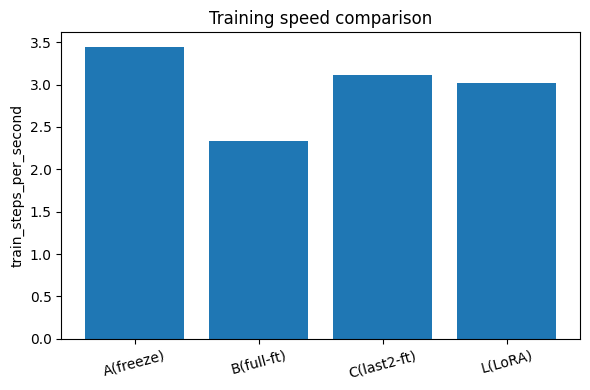

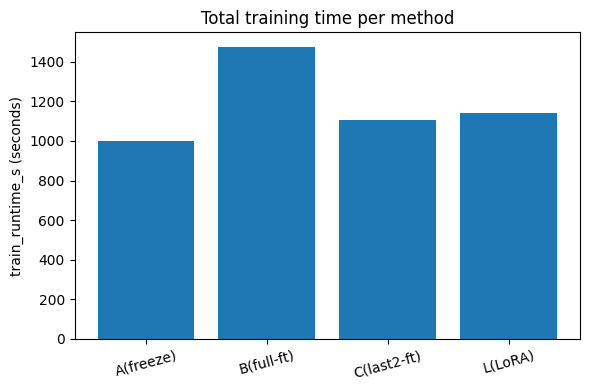

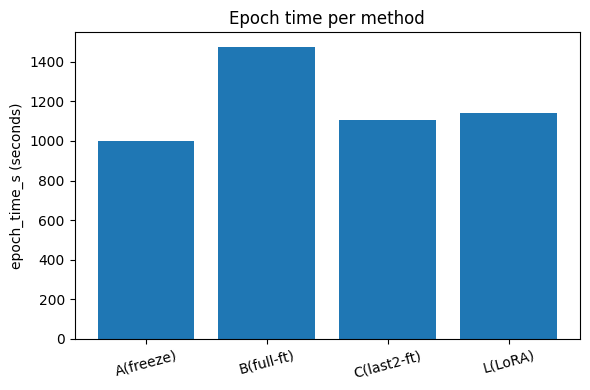

In [55]:
import matplotlib.pyplot as plt

df_plot = df_cost.loc[["A(freeze)", "B(full-ft)", "C(last2-ft)", "L(LoRA)"]]

plt.figure(figsize=(6,4))
plt.bar(df_plot.index, df_plot["train_steps_per_second"])
plt.ylabel("train_steps_per_second")
plt.title("Training speed comparison")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.bar(df_plot.index, df_plot["train_runtime_s"])
plt.ylabel("train_runtime_s (seconds)")
plt.title("Total training time per method")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.bar(df_plot.index, df_plot["epoch_time_s"])
plt.ylabel("epoch_time_s (seconds)")
plt.title("Epoch time per method")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [56]:
from datasets import load_dataset

TARGET = ["yes","no","up","down","left","right","on","off","stop","go"]

ds = load_dataset("speech_commands", "v0.02")

label_names = ds["train"].features["label"].names
print("All labels:", label_names)

target_ids = [label_names.index(t) for t in TARGET]
print("Target ids:", target_ids)

def keep_target(example):
    return example["label"] in target_ids

ds = ds.filter(keep_target)

print({k: len(v) for k, v in ds.items()})

All labels: ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'bed', 'bird', 'cat', 'dog', 'happy', 'house', 'marvin', 'sheila', 'tree', 'wow', 'backward', 'forward', 'follow', 'learn', 'visual', '_silence_']
Target ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
{'train': 30769, 'validation': 3703, 'test': 4074}


In [57]:
import librosa
import numpy as np

def extract_mfcc_from_array(audio_array, sr=16000, n_mfcc=40):
    mfcc = librosa.feature.mfcc(y=audio_array, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)

In [58]:
from tqdm.auto import tqdm

X_train, y_train = [], []
X_val,   y_val   = [], []
X_test,  y_test  = [], []

for split, X, y in [
    ("train", X_train, y_train),
    ("validation", X_val, y_val),
    ("test", X_test, y_test),
]:
    for sample in tqdm(ds[split], desc=f"MFCC {split}"):
        audio_array = sample["audio"]["array"]
        X.append(extract_mfcc_from_array(audio_array))
        y.append(sample["label"])

MFCC test: 100%|███████████████████████████| 4074/4074 [00:08<00:00, 471.86it/s]


In [59]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

X_train = np.stack(X_train)
X_val   = np.stack(X_val)
X_test  = np.stack(X_test)

y_train = np.array(y_train)
y_val   = np.array(y_val)
y_test  = np.array(y_test)

print("Shapes:")
print("X_train:", X_train.shape, " y_train:", y_train.shape)
print("X_val  :", X_val.shape,   " y_val  :", y_val.shape)
print("X_test :", X_test.shape,  " y_test :", y_test.shape)

def eval_model(name, model, X_tr, y_tr, X_v, y_v, X_te, y_te):
    print(f"\n====== {name} ======")

    model.fit(X_tr, y_tr)

    for split, X, y in [("VAL", X_v, y_v), ("TEST", X_te, y_te)]:
        y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        f1  = f1_score(y, y_pred, average="macro")
        print(f"{split} acc = {acc:.4f}, macro F1 = {f1:.4f}")
        print(f"{split} classification report:")
        print(classification_report(y, y_pred, digits=4))


log_reg = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        multi_class="multinomial"
    )
)

eval_model("MFCC + Logistic Regression",
           log_reg,
           X_train, y_train,
           X_val,   y_val,
           X_test,  y_test)


svm_clf = make_pipeline(
    StandardScaler(),
    LinearSVC()
)

eval_model("MFCC + Linear SVM",
           svm_clf,
           X_train, y_train,
           X_val,   y_val,
           X_test,  y_test)

Shapes:
X_train: (30769, 40)  y_train: (30769,)
X_val  : (3703, 40)  y_val  : (3703,)
X_test : (4074, 40)  y_test : (4074,)

====== MFCC + Logistic Regression ======


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


VAL acc = 0.4302, macro F1 = 0.4264
VAL classification report:
              precision    recall  f1-score   support

           0     0.5808    0.6700    0.6222       397
           1     0.4079    0.3325    0.3664       406
           2     0.3773    0.4171    0.3962       350
           3     0.3679    0.3952    0.3811       377
           4     0.3744    0.4148    0.3935       352
           5     0.4604    0.3526    0.3994       363
           6     0.3942    0.5234    0.4497       363
           7     0.4404    0.4263    0.4332       373
           8     0.4318    0.3800    0.4043       350
           9     0.4653    0.3790    0.4178       372

    accuracy                         0.4302      3703
   macro avg     0.4300    0.4291    0.4264      3703
weighted avg     0.4314    0.4302    0.4276      3703

TEST acc = 0.4215, macro F1 = 0.4173
TEST classification report:
              precision    recall  f1-score   support

           0     0.5824    0.7422    0.6527       419
    

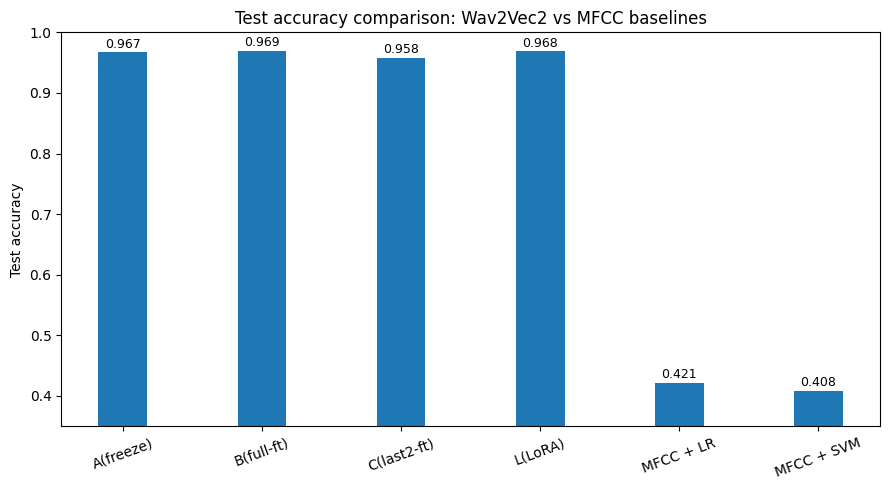

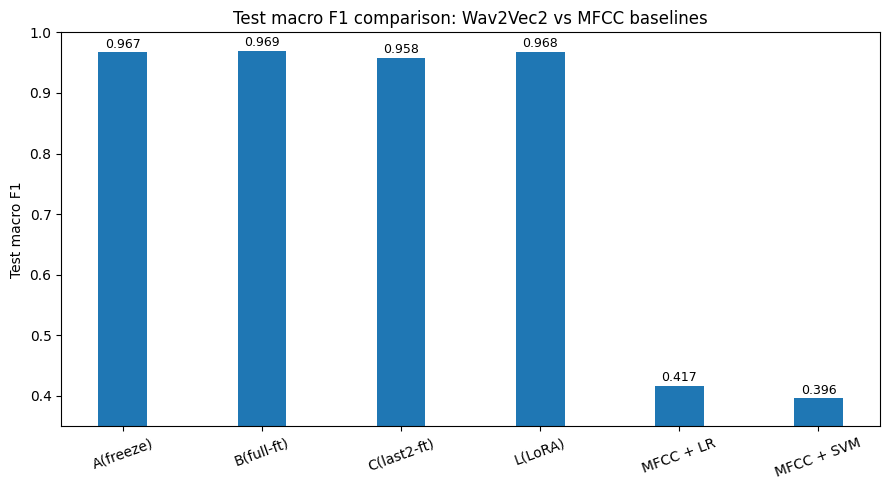

In [60]:
import numpy as np
import matplotlib.pyplot as plt

methods = [
    "A(freeze)",
    "B(full-ft)",
    "C(last2-ft)",
    "L(LoRA)",
    "MFCC + LR",
    "MFCC + SVM",
]

test_acc = np.array([0.9670, 0.9691, 0.9584, 0.9684, 0.4215, 0.4080])
test_f1  = np.array([0.9670, 0.9691, 0.9583, 0.9683, 0.4173, 0.3959])

x = np.arange(len(methods))
width = 0.35

plt.figure(figsize=(9, 5))
bars = plt.bar(x, test_acc, width)
plt.xticks(x, methods, rotation=20)
plt.ylabel("Test accuracy")
plt.title("Test accuracy comparison: Wav2Vec2 vs MFCC baselines")

for b, v in zip(bars, test_acc):
    plt.text(b.get_x() + b.get_width()/2, v + 0.003, f"{v:.3f}", 
             ha="center", va="bottom", fontsize=9)

plt.ylim(0.35, 1.0)
plt.tight_layout()
plt.savefig("figs/baseline_test_accuracy.png", dpi=160)
plt.show()

plt.figure(figsize=(9, 5))
bars = plt.bar(x, test_f1, width)
plt.xticks(x, methods, rotation=20)
plt.ylabel("Test macro F1")
plt.title("Test macro F1 comparison: Wav2Vec2 vs MFCC baselines")

for b, v in zip(bars, test_f1):
    plt.text(b.get_x() + b.get_width()/2, v + 0.003, f"{v:.3f}", 
             ha="center", va="bottom", fontsize=9)

plt.ylim(0.35, 1.0)
plt.tight_layout()
plt.savefig("figs/baseline_test_macroF1.png", dpi=160)
plt.show()

In [61]:
def freeze_all(model):
    freeze_feature_encoder(model)

In [62]:
from peft import LoraConfig, get_peft_model
from types import MethodType

def apply_lora(base_model):

    def dummy_get_input_embeddings(self):
        return None

    base_model.get_input_embeddings = MethodType(dummy_get_input_embeddings, base_model)

    lora_cfg = LoraConfig(
        r=16,
        lora_alpha=32,
        lora_dropout=0.1,
        bias="none",
        target_modules=["q_proj", "k_proj", "v_proj", "out_proj"],
    )

    model_L = get_peft_model(base_model, lora_cfg)

    model_L.print_trainable_parameters()

    return model_L

In [63]:
from types import MethodType
from peft import LoraConfig, get_peft_model

def apply_lora(base_model):
    if hasattr(base_model, "enable_input_require_grads"):
        def _dummy_enable_input_require_grads(self):
            # 什么都不做
            return None
        base_model.enable_input_require_grads = MethodType(
            _dummy_enable_input_require_grads, base_model
        )

    def dummy_get_input_embeddings(self):
        return None

    base_model.get_input_embeddings = MethodType(
        dummy_get_input_embeddings, base_model
    )

    lora_cfg = LoraConfig(
        r=16,
        lora_alpha=32,
        lora_dropout=0.1,
        bias="none",
        target_modules=["q_proj", "k_proj", "v_proj", "out_proj"], 
    )

    model_L = get_peft_model(base_model, lora_cfg)

    model_L.print_trainable_parameters()

    return model_L

In [64]:
def train_with_fraction(model_type, frac):
    n = int(len(train_enc) * frac)
    idx = np.random.choice(len(train_enc), n, replace=False)
    train_subset = train_enc.select(idx)

    base_model = build_model()

    if model_type == "freeze":
        freeze_all(base_model)
        model = base_model
    elif model_type == "last2":
        partial_unfreeze_last2(base_model)
        model = base_model
    elif model_type == "lora":
        model = apply_lora(base_model)
    else:
        raise ValueError(f"Unknown model_type: {model_type}")

    args = TrainingArguments(
        output_dir=f"runs/data_eff_{model_type}_{frac}",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=1,
        learning_rate=5e-5,
        num_train_epochs=1,
        logging_steps=50,
        report_to="none",
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_subset,
        eval_dataset=val_enc,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    test_eval = trainer.evaluate(test_enc)

    return test_eval["eval_f1_macro"], test_eval["eval_acc"]

In [65]:
fractions = [0.05, 0.1, 0.2, 0.5, 1.0]

results = {
    "freeze": [],
    "last2": [],
    "lora": [],
}

for frac in fractions:
    print(f"\n=== Fraction: {frac} ===")
    for m in ["freeze", "last2", "lora"]:
        f1, acc = train_with_fraction(m, frac)
        results[m].append(f1)
        print(m, "F1 =", round(f1, 4), "ACC =", round(acc, 4))


=== Fraction: 0.05 ===


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs

Step,Training Loss
50,2.294300
100,2.224400
150,1.978300


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


freeze F1 = 0.8379 ACC = 0.8384


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,2.282900
100,2.185300
150,2.072500


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


last2 F1 = 0.4053 ACC = 0.4375


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,179,648 || all params: 95,750,794 || trainable%: 1.2320


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,2.303100
100,2.299200
150,2.302700


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


lora F1 = 0.0761 ACC = 0.1257

=== Fraction: 0.1 ===


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs

Step,Training Loss
50,2.276900
100,1.943000
150,1.537900
200,1.282200
250,1.131400
300,0.991600


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


freeze F1 = 0.9277 ACC = 0.9275


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,2.260200
100,2.125900
150,1.900800
200,1.740900
250,1.617400
300,1.499500


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


last2 F1 = 0.5057 ACC = 0.5366


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,179,648 || all params: 95,750,794 || trainable%: 1.2320


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,2.305700
100,2.303900
150,2.299600
200,2.296100
250,2.299100
300,2.291300


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


lora F1 = 0.0838 ACC = 0.1274

=== Fraction: 0.2 ===


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs

Step,Training Loss
50,2.290200
100,2.204300
150,1.857100
200,1.519500
250,1.326700
300,1.159700
350,1.068400
400,0.966900
450,0.868200
500,0.806500


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


freeze F1 = 0.9602 ACC = 0.9603


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,2.278000
100,2.120800
150,1.835500
200,1.638100
250,1.477100
300,1.240900
350,1.202600
400,0.992200
450,0.949100
500,0.873300


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


last2 F1 = 0.8647 ACC = 0.8664


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,179,648 || all params: 95,750,794 || trainable%: 1.2320


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,2.301200
100,2.301000
150,2.294600
200,2.290700
250,2.280800
300,2.254000
350,2.208900
400,2.123000
450,2.067000
500,2.040000


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


lora F1 = 0.2096 ACC = 0.3232

=== Fraction: 0.5 ===


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs

Step,Training Loss
50,2.261500
100,1.903400
150,1.450300
200,1.399600
250,1.185000
300,0.988300
350,0.880300
400,0.727600
450,0.735900
500,0.578000


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


freeze F1 = 0.9626 ACC = 0.9621


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,2.268300
100,2.127200
150,1.826300
200,1.561500
250,1.284000
300,1.147100
350,0.967500
400,0.867300
450,0.662300
500,0.695000


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


last2 F1 = 0.9469 ACC = 0.9469


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,179,648 || all params: 95,750,794 || trainable%: 1.2320


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,2.300500
100,2.301400
150,2.293800
200,2.291300
250,2.284000
300,2.253600
350,2.193400
400,2.090500
450,2.014400
500,1.964100


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and wi

lora F1 = 0.8989 ACC = 0.9004

=== Fraction: 1.0 ===


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs

Step,Training Loss
50,2.268000
100,1.998900
150,1.691300
200,1.440500
250,1.276400
300,1.009000
350,0.950000
400,0.884700
450,0.700700
500,0.727900


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch

freeze F1 = 0.9679 ACC = 0.9679


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,2.276400
100,2.128100
150,1.851300
200,1.577500
250,1.272500
300,1.072900
350,0.888300
400,0.751800
450,0.646800
500,0.555200


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


last2 F1 = 0.9569 ACC = 0.9569


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,179,648 || all params: 95,750,794 || trainable%: 1.2320


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,2.305800
100,2.302600
150,2.296500
200,2.287800
250,2.254100
300,2.166900
350,2.090900
400,2.017100
450,1.958800
500,1.923800


/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/opt/anaconda3/envs/pytorch310/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and wi

lora F1 = 0.9611 ACC = 0.9611


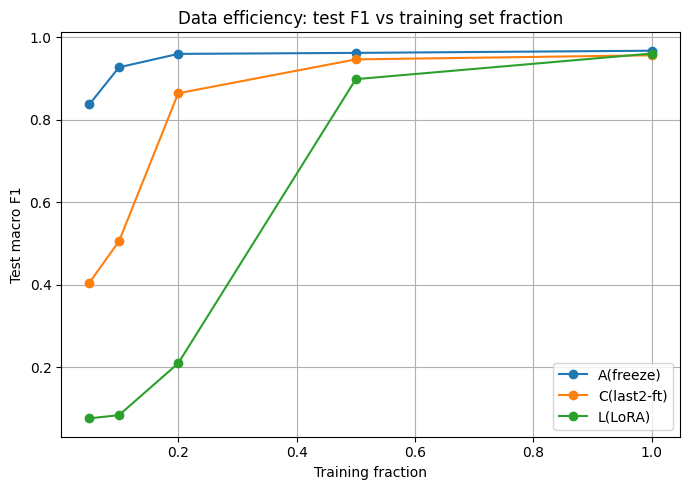

In [66]:
plt.figure(figsize=(7,5))
method_labels = {
    "freeze": "A(freeze)",
    "last2": "C(last2-ft)",
    "lora": "L(LoRA)",
}

for m in ["freeze", "last2", "lora"]:
    plt.plot(fractions, results[m], marker="o", label=method_labels[m])

plt.xlabel("Training fraction")
plt.ylabel("Test macro F1")
plt.title("Data efficiency: test F1 vs training set fraction")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/fig_data_efficiency.png", dpi=150)
plt.show()

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


methods = [
    "A(freeze)",
    "B(full-ft)",
    "C(last2-ft)",
    "L(LoRA)",
    "MFCC + LR",
    "MFCC + SVM"
]

# Test accuracy
test_acc = [
    0.9670,  
    0.9691, 
    0.9584,
    0.9683, 
    0.4215,
    0.4080 
]

# Test F1
test_f1 = [
    0.9670,
    0.9691,
    0.9583,
    0.9683,
    0.4173,
    0.3959 
]

# Training runtime (seconds)
train_runtime = [
    994.85,   
    1441.47,   
    1320.64,
    1221.83, 
    None,     
    None      
]

# Epoch time (seconds)
epoch_time = train_runtime 

# Training speed: steps/sec
steps_per_sec = [
    3.462, 
    2.389,
    2.608,
    2.819,
    None, 
    None
]

df_final = pd.DataFrame({
    "Test Accuracy": test_acc,
    "Test Macro F1": test_f1,
    "Train Runtime (s)": train_runtime,
    "Epoch Time (s)": epoch_time,
    "Steps/sec": steps_per_sec,
}, index=methods)

print(df_final)
df_final

             Test Accuracy  Test Macro F1  Train Runtime (s)  Epoch Time (s)  \
A(freeze)           0.9670         0.9670             994.85          994.85   
B(full-ft)          0.9691         0.9691            1441.47         1441.47   
C(last2-ft)         0.9584         0.9583            1320.64         1320.64   
L(LoRA)             0.9683         0.9683            1221.83         1221.83   
MFCC + LR           0.4215         0.4173                NaN             NaN   
MFCC + SVM          0.4080         0.3959                NaN             NaN   

             Steps/sec  
A(freeze)        3.462  
B(full-ft)       2.389  
C(last2-ft)      2.608  
L(LoRA)          2.819  
MFCC + LR          NaN  
MFCC + SVM         NaN  


,Test Accuracy,Test Macro F1,Train Runtime (s),Epoch Time (s),Steps/sec
A(freeze),0.9670,0.9670,994.85,994.85,3.462
B(full-ft),0.9691,0.9691,1441.47,1441.47,2.389
C(last2-ft),0.9584,0.9583,1320.64,1320.64,2.608
L(LoRA),0.9683,0.9683,1221.83,1221.83,2.819
MFCC + LR,0.4215,0.4173,NaN,NaN,NaN
MFCC + SVM,0.4080,0.3959,NaN,NaN,NaN


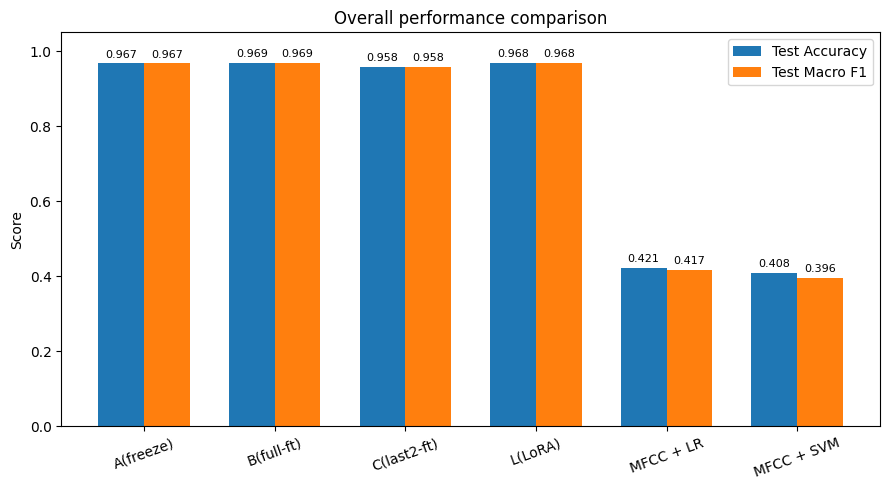

In [68]:
x = np.arange(len(methods))
width = 0.35

plt.figure(figsize=(9, 5))
bars1 = plt.bar(x - width/2, df_final["Test Accuracy"], width, label="Test Accuracy")
bars2 = plt.bar(x + width/2, df_final["Test Macro F1"], width, label="Test Macro F1")

plt.xticks(x, methods, rotation=20)
plt.ylabel("Score")
plt.title("Overall performance comparison")
plt.ylim(0.0, 1.05)
plt.legend()

for b in bars1:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h + 0.01, f"{h:.3f}",
             ha="center", va="bottom", fontsize=8)

for b in bars2:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h + 0.01, f"{h:.3f}",
             ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.savefig("figs/final_perf_comparison.png", dpi=160)
plt.show()

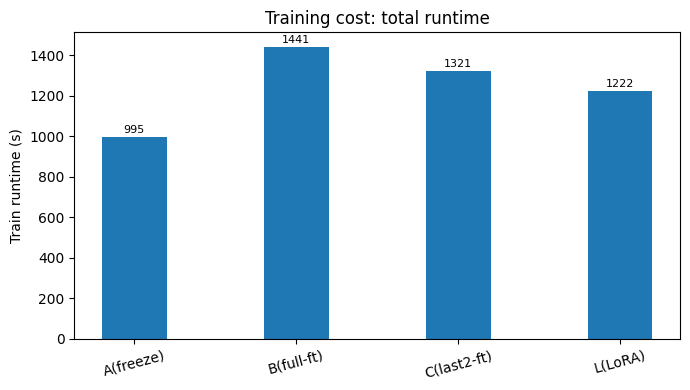

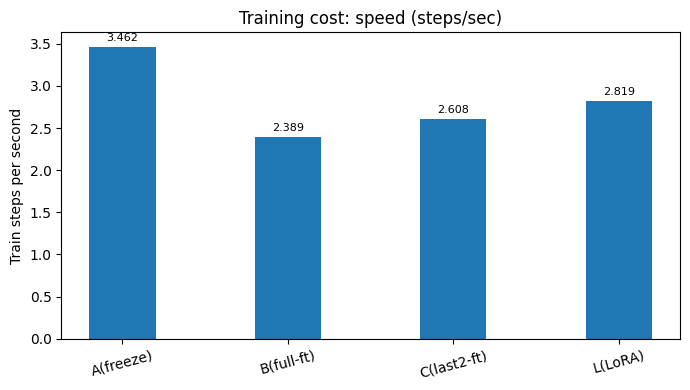

In [69]:
cost_methods = ["A(freeze)", "B(full-ft)", "C(last2-ft)", "L(LoRA)"]
df_cost = df_final.loc[cost_methods]

x = np.arange(len(cost_methods))
width = 0.4

plt.figure(figsize=(7,4))
bars = plt.bar(x, df_cost["Train Runtime (s)"], width)
plt.xticks(x, cost_methods, rotation=15)
plt.ylabel("Train runtime (s)")
plt.title("Training cost: total runtime")

for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h + 10, f"{h:.0f}",
             ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.savefig("figs/final_runtime_comparison.png", dpi=160)
plt.show()

plt.figure(figsize=(7,4))
bars = plt.bar(x, df_cost["Steps/sec"], width)
plt.xticks(x, cost_methods, rotation=15)
plt.ylabel("Train steps per second")
plt.title("Training cost: speed (steps/sec)")

for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h + 0.05, f"{h:.3f}",
             ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.savefig("figs/final_speed_comparison.png", dpi=160)
plt.show()